# Trying to use nearest neigbors multiple models for classifications

In [1]:
import turicreate as tc

In [2]:
image_train = tc.SFrame('./data/image_train_data')
image_test = tc.SFrame('./data/image_test_data')

In [3]:
sketch = tc.Sketch(image_train['label'])
sketch


+------------------+-------+----------+
|       item       | value | is exact |
+------------------+-------+----------+
|      Length      |  2005 |   Yes    |
| # Missing Values |   0   |   Yes    |
| # unique values  |   4   |    No    |
+------------------+-------+----------+

Most frequent items:
+------------+-------+
|   value    | count |
+------------+-------+
|    cat     |  509  |
|    dog     |  509  |
| automobile |  509  |
|    bird    |  478  |
+------------+-------+


# Create category-specific image retrieval models

Steps:

1) Splitting the training data into 4 different SFrame data structures. Each will contain data for one of the four categories image categories.

2) Creating a nearest neighbor model using deep features for each category.

### Grouping data by label

In [4]:
cat_images = image_train[image_train['label']=='cat']
dog_images = image_train[image_train['label']=='dog']
automobile_images = image_train[image_train['label']=='automobile']
bird_images = image_train[image_train['label']=='bird']

Creating the four models using the entire grouped by label training data.

In [5]:
cat_model = tc.nearest_neighbors.create(cat_images, features=['deep_features'], label='id')
dog_model = tc.nearest_neighbors.create(dog_images, features=['deep_features'], label='id')
automobile_model = tc.nearest_neighbors.create(automobile_images, features=['deep_features'], label='id')
bird_model = tc.nearest_neighbors.create(bird_images, features=['deep_features'], label='id')

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

# Using Models

Using the four created specialized models to answer the following questions:

* What is the nearest cat-labeled image in the training data to the cat image that is the first image in the test data ?

* What is the nearest dog-labeled image in the training data to the cat image that is the first image in the test data?

,SArray
0,

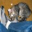

In [6]:
test_image = image_test[0:1]
test_image['image'].explore()

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 5.473ms      |

| Done         |         | 100         | 26.523ms     |

+--------------+---------+-------------+--------------+

,SArray
0,

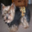

In [7]:
dog_query = dog_model.query(test_image, k=1)
dog_query_result = image_train[image_train['id'] == dog_query[0]['reference_label']]
dog_query_result['image'].explore()

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 3.785ms      |

| Done         |         | 100         | 27.153ms     |

+--------------+---------+-------------+--------------+

,SArray
0,

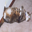

In [8]:
cat_query = cat_model.query(test_image, k=1)
cat_query_result = image_train[image_train['id'] == cat_query[0]['reference_label']]
cat_query_result['image'].explore()

# Trying classification by calculating the mean distance of the first 5 query images

In [9]:
cat_query = cat_model.query(test_image)
cat_query

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 4.064ms      |

| Done         |         | 100         | 30.524ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,16289,34.62371920804245,1
0,45646,36.00687992842462,2
0,32139,36.52008134363789,3
0,25713,36.754850252057054,4
0,331,36.87312281675268,5


In [10]:
cat_query['distance'].mean()

36.15573070978294

In [11]:
dog_query = dog_model.query(test_image)
dog_query

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 4.388ms      |

| Done         |         | 100         | 27.845ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,16976,37.464262878423774,1
0,13387,37.56668321685285,2
0,35867,37.60472670789396,3
0,44603,37.70655851529755,4
0,6094,38.511325490739715,5


In [12]:
dog_query['distance'].mean()

37.77071136184157

Conclusion:
* The classifier built on the mean distance of the first 5 nearest estimation by every model can work.

# Computing the nearest neighbor classifer accuracy

In [13]:
cat_images_train, cat_images_test = image_train[image_train['label']=='cat'].random_split(0.8, seed=0)
dog_images_train, dog_images_test = image_train[image_train['label']== 'dog'].random_split(0.8, seed=0)
automobile_images_train, automobile_images_test = image_train[image_train['label']== 'automobile'].random_split(0.8, seed=0)
bird_images_train, bird_images_test = image_train[image_train['label']=='bird'].random_split(0.8, seed=0)

In [14]:
cat_model = tc.nearest_neighbors.create(cat_images_train, features=['deep_features'], label='id')
dog_model = tc.nearest_neighbors.create(dog_images_train, features=['deep_features'], label='id')
automobile_model = tc.nearest_neighbors.create(automobile_images_train, features=['deep_features'], label='id')
bird_model = tc.nearest_neighbors.create(bird_images_train, features=['deep_features'], label='id')


Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

In [15]:
dog_cat_neighbors = cat_model.query(dog_images_test, k=1)
dog_dog_neighbors = dog_model.query(dog_images_test, k=1)
dog_automobile_neighbors = automobile_model.query(dog_images_test, k=1)
dog_bird_neighbors = bird_model.query(dog_images_test, k=1)


Starting blockwise querying.

max rows per data block: 4348

number of reference data blocks: 8

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 107          | 5350    | 12.4378     | 29.894ms     |

| Done         | 43014   | 100         | 39.158ms     |

+--------------+---------+-------------+--------------+

Starting blockwise querying.

max rows per data block: 4348

number of reference data blocks: 8

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 107          | 5350    | 12.4378     | 25.12ms      |

| Done         | 43014   | 100         | 39.649ms     |

+--------------+---------+-------------+--------------+

Starting blockwise querying.

max rows per data block: 4348

number of reference data blocks: 8

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 107          | 5350    | 12.4378     | 25.445ms     |

| Done         | 43014   | 100         | 39.582ms     |

+--------------+---------+-------------+--------------+

Starting blockwise querying.

max rows per data block: 4348

number of reference data blocks: 8

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 107          | 5029    | 12.4011     | 20.741ms     |

| Done         | 40553   | 100         | 38.495ms     |

+--------------+---------+-------------+--------------+

In [16]:
dog_distances = tc.SFrame()
dog_distances['dog-dog'] = dog_dog_neighbors['distance']
dog_distances['dog-cat'] = dog_cat_neighbors['distance']
dog_distances['dog-autombile'] = dog_automobile_neighbors['distance']
dog_distances['dog-bird'] = dog_bird_neighbors['distance']
dog_distances

dog-dog,dog-cat,dog-autombile,dog-bird
38.1444321002462,37.014743351067715,34.21311380457997,36.40758907870294
30.38487709815324,33.37580667605238,42.559646898763454,34.32822477093872
31.1043339363443,31.985592744704487,40.68453295713595,32.33214767460644
34.606525417505175,40.09177471026958,45.63913691191106,41.399670063386715
37.39024435526018,40.094266784576256,40.02420380334464,42.461162205298216
36.44676716207503,36.271940889771464,44.0137776519868,38.20124576827323
42.602112565225106,43.73524788022245,46.32318412379065,44.45186483700512
37.33265425552528,34.96726075309989,43.296002617049886,37.79391931293298
35.516454919886556,35.38874441955616,40.55823473471309,36.95806635657703
33.60392171912039,35.340378794536136,42.417882787533216,40.666821489743064


In [17]:
dog_cat_neighbors.head()

query_label,reference_label,distance,rank
0,16864,37.014743351067715,1
1,42056,33.37580667605238,1
2,8302,31.985592744704487,1
3,27753,40.09177471026958,1
4,42056,40.094266784576256,1
5,18233,36.271940889771464,1
6,3514,43.73524788022245,1
7,11809,34.96726075309989,1
8,42131,35.38874441955616,1
9,40914,35.340378794536136,1


### Compute the number of correct predictions using 1-nearest neighbors for the dog class.

In [18]:
def is_dog_correct(row):
    if row['dog-dog'] < row['dog-cat'] and row['dog-dog'] < row['dog-autombile'] and row['dog-dog'] < row['dog-bird']:
        return 1
    else:
        return 0
accuracy = dog_distances.apply(is_dog_correct).sum()/len(dog_distances)
print('Accuracy of the classifier built over the neares neighbor partitioned model:', accuracy)


Accuracy of the classifier built over the neares neighbor partitioned model: 0.6822429906542056
